In [1]:
import torch
import matplotlib.pyplot as plt
from OUR_utils.utils import *
from Models.model import ConTextTransformer

In [2]:
config = dict(
     epochs=70,
     classes=28,
     batch_size=128,
     learning_rate=0.001,
     input_size=256,
     dim = 256,
     depth = 2,
     heads = 4,
     mlp_dim = 512,
     dataset="Con-Text dataset",
     architecture="ConTextTransformer")
device = 'cuda'

In [3]:
path_weights_Model = ""
Model = ConTextTransformer(num_classes = config["classes"], dim = 256, depth = 2, heads = 4, mlp_dim = 512)
Model.load_state_dict(torch.load('/home/xnmaster/dlnn-project_ia-group_1/CheckPoints/model_state_dict_ADAMW.pth'))
Model = Model.to(device)

/anaconda/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/anaconda/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
directory_test_train_files = '/home/xnmaster/data/'            
images_directory           = '/home/xnmaster/data/JPEGImages/'
fasttext_obj = fasttext.load_model('/home/xnmaster/cc.en.300.bin')
input_size   = 256
batch_size   = 128

test  = ConTextDataset(directory_test_train_files, images_directory, fasttext_obj, train = False, transform = get_transform(input_size, train = False))
test_loader   = make_loader(test,  batch_size=batch_size)

In [5]:
business_dict = {
    0: "Bakery",
    1: "Barber",
    2: "Bistro",
    3: "Bookstore",
    4: "Cafe",
    5: "ComputerStore",
    6: "CountryStore",
    7: "Diner",
    8: "DiscountHouse",
    9: "Dry Cleaner",
    10: "Funeral",
    11: "Hotspot",
    12: "MassageCenter",
    13: "MedicalCenter",
    14: "PackingStore",
    15: "PawnShop",
    16: "PetShop",
    17: "Pharmacy",
    18: "Pizzeria",
    19: "RepairShop",
    20: "Restaurant",
    21: "School",
    22: "SteakHouse",
    23: "Tavern",
    24: "TeaHouse",
    25: "Theatre",
    26: "Tobacco",
    27: "Motel"
}

Correctly predicted: 64.0625%


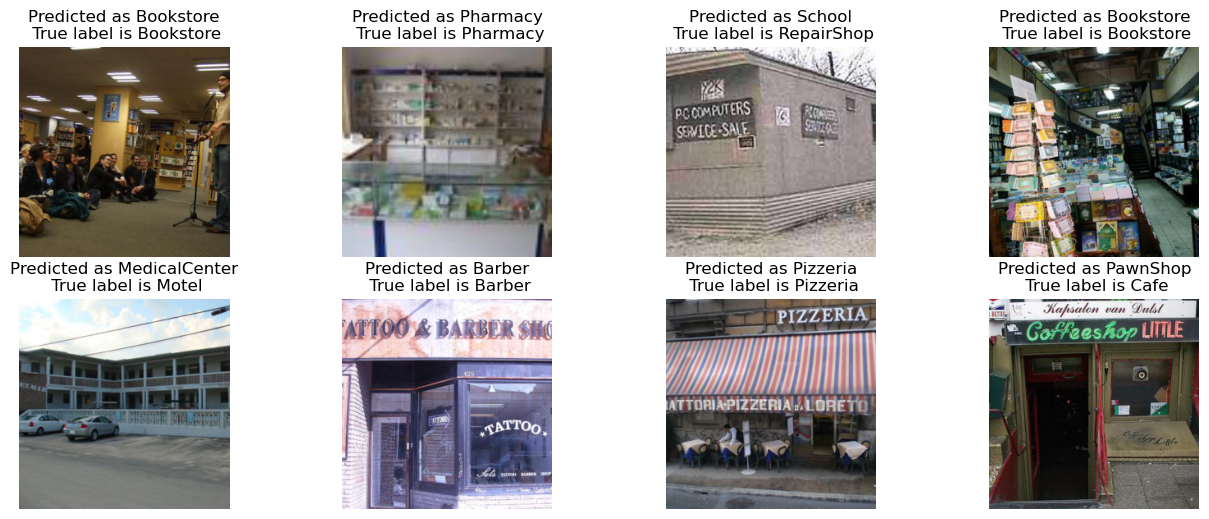

In [6]:
with torch.no_grad():

    img, text, target = next(iter(test_loader))
    img, text, target = img.to(device), text.to(device), target.to(device)

    output = Model(img, text)
    predictions = np.argmax(output.cpu().numpy(), axis=1).tolist()
    true = target.cpu().numpy().tolist()
      
    plt.figure(figsize=(16, 6))
    
    print("Correctly predicted: {}%".format(100*sum(p == t for p, t in zip(predictions, true))/len(predictions)) )

    for i in range(8):
        plt.subplot(2, 4, i + 1)
        
        image = img[i,...].cpu().clone().detach() # Create a copy of the tensor in the CPU
        image = image.permute(1, 2, 0) # The original tensor is formatted as Channels, Height, Width - move channels to the end
        image = image.numpy()

        # Undo the normalisation we applied before
        image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        image = image.clip(0, 1)

        plt.imshow(image)
        
        plt.axis('off')
        plt.title('Predicted as {}\n True label is {}'.format(business_dict[predictions[i]], business_dict[true[i]], ))

In [15]:
y_pred = []
y_true = []

with torch.no_grad():

    for img, text, target in test_loader:
        img, text, target = img.to(device), text.to(device), target.to(device)

        output = Model(img, text)
        predictions = np.argmax(output.cpu().numpy(), axis=1).tolist()
        true = target.cpu().numpy().tolist()

        y_pred.append(predictions)
        y_true.append(true)

In [16]:
y_pred = [[business_dict.get(key) for key in inner_list] for inner_list in y_pred]
y_true = [[business_dict.get(key) for key in inner_list] for inner_list in y_true]

In [18]:
from sklearn.preprocessing import LabelBinarizer
from itertools import chain
from sklearn.metrics import classification_report, confusion_matrix


def bio_classification_report(y_true, y_pred):
    """

    Classification report.
    You can use this as evaluation for both in the baseline model and new model.
    """
    lb = LabelBinarizer()
    y_true_combined = lb.fit_transform(list(chain.from_iterable(y_true)))
    y_pred_combined = lb.transform(list(chain.from_iterable(y_pred)))
        
    tagset = set(lb.classes_) - {'O'}
    tagset = sorted(tagset, key=lambda tag: tag.split('-', 1)[::-1])
    class_indices = {cls: idx for idx, cls in enumerate(lb.classes_)}
    
    return classification_report(
        y_true_combined,
        y_pred_combined,
        labels = [class_indices[cls] for cls in tagset],
        target_names = tagset,
    )

In [21]:
predictions = bio_classification_report(y_pred, y_true)
print('ConTextTransformer', predictions)

ConTextTransformer                precision    recall  f1-score   support

       Bakery       0.72      0.77      0.75       377
       Barber       0.84      0.70      0.76       628
       Bistro       0.13      0.33      0.18        36
    Bookstore       0.78      0.76      0.77       454
         Cafe       0.18      0.68      0.28        73
ComputerStore       0.44      0.88      0.59        48
 CountryStore       0.61      0.37      0.46       673
        Diner       0.49      0.81      0.61       226
  Dry Cleaner       0.65      0.60      0.62       428
      Funeral       0.58      0.68      0.63       284
      Hotspot       0.33      1.00      0.50         8
MassageCenter       0.51      0.90      0.65        52
MedicalCenter       0.65      0.68      0.67       384
        Motel       0.64      0.64      0.64       377
 PackingStore       0.54      0.42      0.48       499
     PawnShop       0.48      0.57      0.52       140
      PetShop       0.74      0.82      0.78 

/anaconda/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
